<a href="https://colab.research.google.com/github/Ayush-Dutta/Brain_Tumor_Detection/blob/main/Another_copy_of_Final_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayushdutta2512","key":"54d96319910adb6fd66f466cf6a27f91"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download ayushdutta2512/brain-tumor-datasetfor-binary-classification

Dataset URL: https://www.kaggle.com/datasets/ayushdutta2512/brain-tumor-datasetfor-binary-classification
License(s): unknown


In [ ]:
!unzip brain-tumor-datasetfor-binary-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0178.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0179.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0180.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0181.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0182.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0183.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0184.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0185.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0186.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0187.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0188.jpg  
  inflating: Brain Tumor Dataset(for binary classification

# Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Set environment log level for TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Consolidated Keras and TensorFlow imports
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# Set seeds for reproducibility
SEED = 40
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Preparing the Image Data

Dataset folders: ['yes', 'no']
2 directories and 0 images in /content/Brain Tumor Dataset(for binary classification)
0 directories and 23784 images in /content/Brain Tumor Dataset(for binary classification)/yes
0 directories and 5164 images in /content/Brain Tumor Dataset(for binary classification)/no


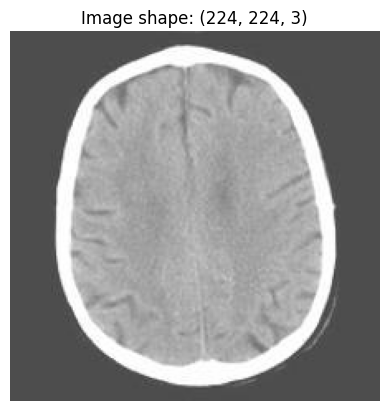

In [ ]:
# Define main constants
MAIN_DIR = "/content/Brain Tumor Dataset(for binary classification)"
IMG_SHAPE = (128, 128)
BATCH_SIZE = 32

# ----------------------
# Inspect Dataset Structure
# ----------------------
print("Dataset folders:", os.listdir(MAIN_DIR))
for dirpath, dirnames, filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

# ----------------------
# Function: View a Random Image
# ----------------------
def view_random_image():
    subdirs = ['yes', 'no']  # Use folder names without a trailing slash
    subdir = random.choice(subdirs)
    target_folder = os.path.join(MAIN_DIR, subdir)
    random_image = random.choice(os.listdir(target_folder))
    img_path = os.path.join(target_folder, random_image)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        return
    # Convert BGR to RGB for proper display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Image shape: {img.shape}")
    plt.show()

# View a random image from the dataset
view_random_image()


# Image Data Generator

In [ ]:
datagen = ImageDataGenerator(rescale=1/255., validation_split=0.5)

train_data = datagen.flow_from_directory(
    MAIN_DIR,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    subset="training",
    seed=SEED
)

test_data = datagen.flow_from_directory(
    MAIN_DIR,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    subset="validation",
    seed=SEED
)

Found 14474 images belonging to 2 classes.
Found 14474 images belonging to 2 classes.


In [ ]:
print(f"Training samples: {train_data.samples}, Validation samples: {test_data.samples}")


Training samples: 14474, Validation samples: 14474


# Convolutional Neural Network

In [ ]:
cnn_model = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)),
    Conv2D(32, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(32, kernel_size=3, activation='relu'),
    Conv2D(16, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, padding='same'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss=BinaryCrossentropy(), optimizer=Adam(), metrics=["accuracy"])

steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = test_data.samples // test_data.batch_size

# Define callbacks for the CNN model
cnn_checkpoint = ModelCheckpoint('best_model1.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn = cnn_model.fit(
    train_data,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_data,
    validation_steps=validation_steps,
    callbacks=[cnn_checkpoint, early_stop]
)


Epoch 1/10
451/452 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8721 - loss: 0.3444
Epoch 1: val_accuracy improved from -inf to 0.87431, saving model to best_model1.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 55s 105ms/step - accuracy: 0.8722 - loss: 0.3440 - val_accuracy: 0.8743 - val_loss: 0.3052
Epoch 2/10
  1/452 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9688 - loss: 0.0694
Epoch 2: val_accuracy did not improve from 0.87431
452/452 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9688 - loss: 0.0694 - val_accuracy: 0.8740 - val_loss: 0.3024
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9509 - loss: 0.1303
Epoch 3: val_accuracy improved from 0.87431 to 0.88793, saving model to best_model1.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9509 - loss: 0.1303 - val_accuracy: 0.8879 - val_loss: 0.2999
Epoch 4/10
  1/452 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9688 - loss: 0.0869
Epoch 4: val_accuracy improved from 0.88793 to 0.89775, saving model to best_model1.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9688 - loss: 0.0869 - val_accuracy: 0.8977 - val_loss: 0.2660
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9679 - loss: 0.0915
Epoch 5: val_accuracy improved from 0.89775 to 0.91130, saving model to best_model1.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 85s 134ms/step - accuracy: 0.9679 - loss: 0.0915 - val_accuracy: 0.9113 - val_loss: 0.2575
Epoch 6/10
  1/452 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 1.0000 - loss: 0.0426
Epoch 6: val_accuracy improved from 0.91130 to 0.91482, saving model to best_model1.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 1.0000 - loss: 0.0426 - val_accuracy: 0.9148 - val_loss: 0.2521
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9830 - loss: 0.0523
Epoch 7: val_accuracy did not improve from 0.91482
452/452 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - accuracy: 0.9830 - loss: 0.0523 - val_accuracy: 0.9091 - val_loss: 0.2568
Epoch 8/10
  1/452 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 1.0000 - loss: 0.0155
Epoch 8: val_accuracy did not improve from 0.91482
452/452 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 1.0000 - loss: 0.0155 - val_accuracy: 0.9078 - val_loss: 0.2593
Epoch 9/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9855 - loss: 0.0443
Epoch 9: val_accuracy improved from 0.91482 to 0.92215, saving model to best_model1.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 82s 181ms/step - accuracy: 0.9855 - loss: 0.0443 - val_accuracy: 0.9222 - val_loss: 0.3061


# Evaluation

In [ ]:
# Function to plot loss curves
def plot_curves(history, title_prefix=""):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(loss))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title(f"{title_prefix} Loss Curves")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title(f"{title_prefix} Accuracy Curves")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()

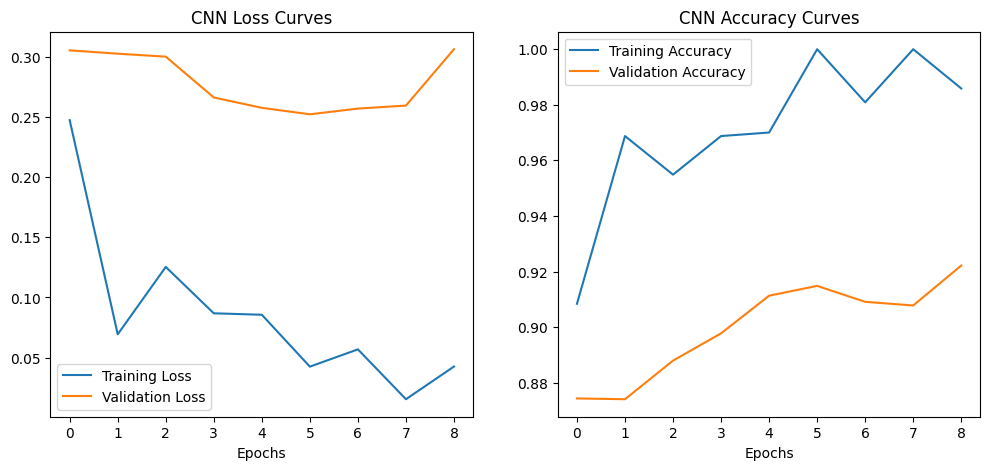

In [ ]:
plot_curves(history_cnn, title_prefix="CNN")

In [ ]:
result_cnn = cnn_model.evaluate(test_data, verbose=2)
print(f"CNN Evaluation Accuracy: {result_cnn[1]*100:.2f}%\nLoss: {result_cnn[0]:.4f}")

453/453 - 18s - 40ms/step - accuracy: 0.9149 - loss: 0.2519
CNN Evaluation Accuracy: 91.49%
Loss: 0.2519


## Transfer Learning with VGG16

The CNN model fails to perform well when train test split is introduced. Therefore, transfer learning has been introduced which gives us great results. It is trained with half the dataset, but still manages to produce great numbers.

###Transfer Learning:
Transfer learning is a technique in machine learning where a model that has been trained on one task is reused or adapted for a different but related task. Here’s a simple explanation:


*  **Learning from Experience:** Imagine you learn to ride a bicycle. Once you know how to balance and pedal on one type of bike, it’s much easier to ride a different type of bike, like a mountain bike or a racing bike. You’re not starting from scratch; you’re using what you already learned.

*  **Applying Knowledge:** In the same way, transfer learning allows a computer program (or model) that has learned to recognize certain patterns in a large dataset (like identifying everyday objects in photos) to apply that knowledge to a new, different task (like recognizing diseases in medical images).

*  **Saving Time and Resources:**Training a machine learning model from the ground up can take a lot of time, data, and computing power. With transfer learning, we can take an existing model that has already learned useful features and fine-tune it for our specific needs. This process is often faster and requires less data.

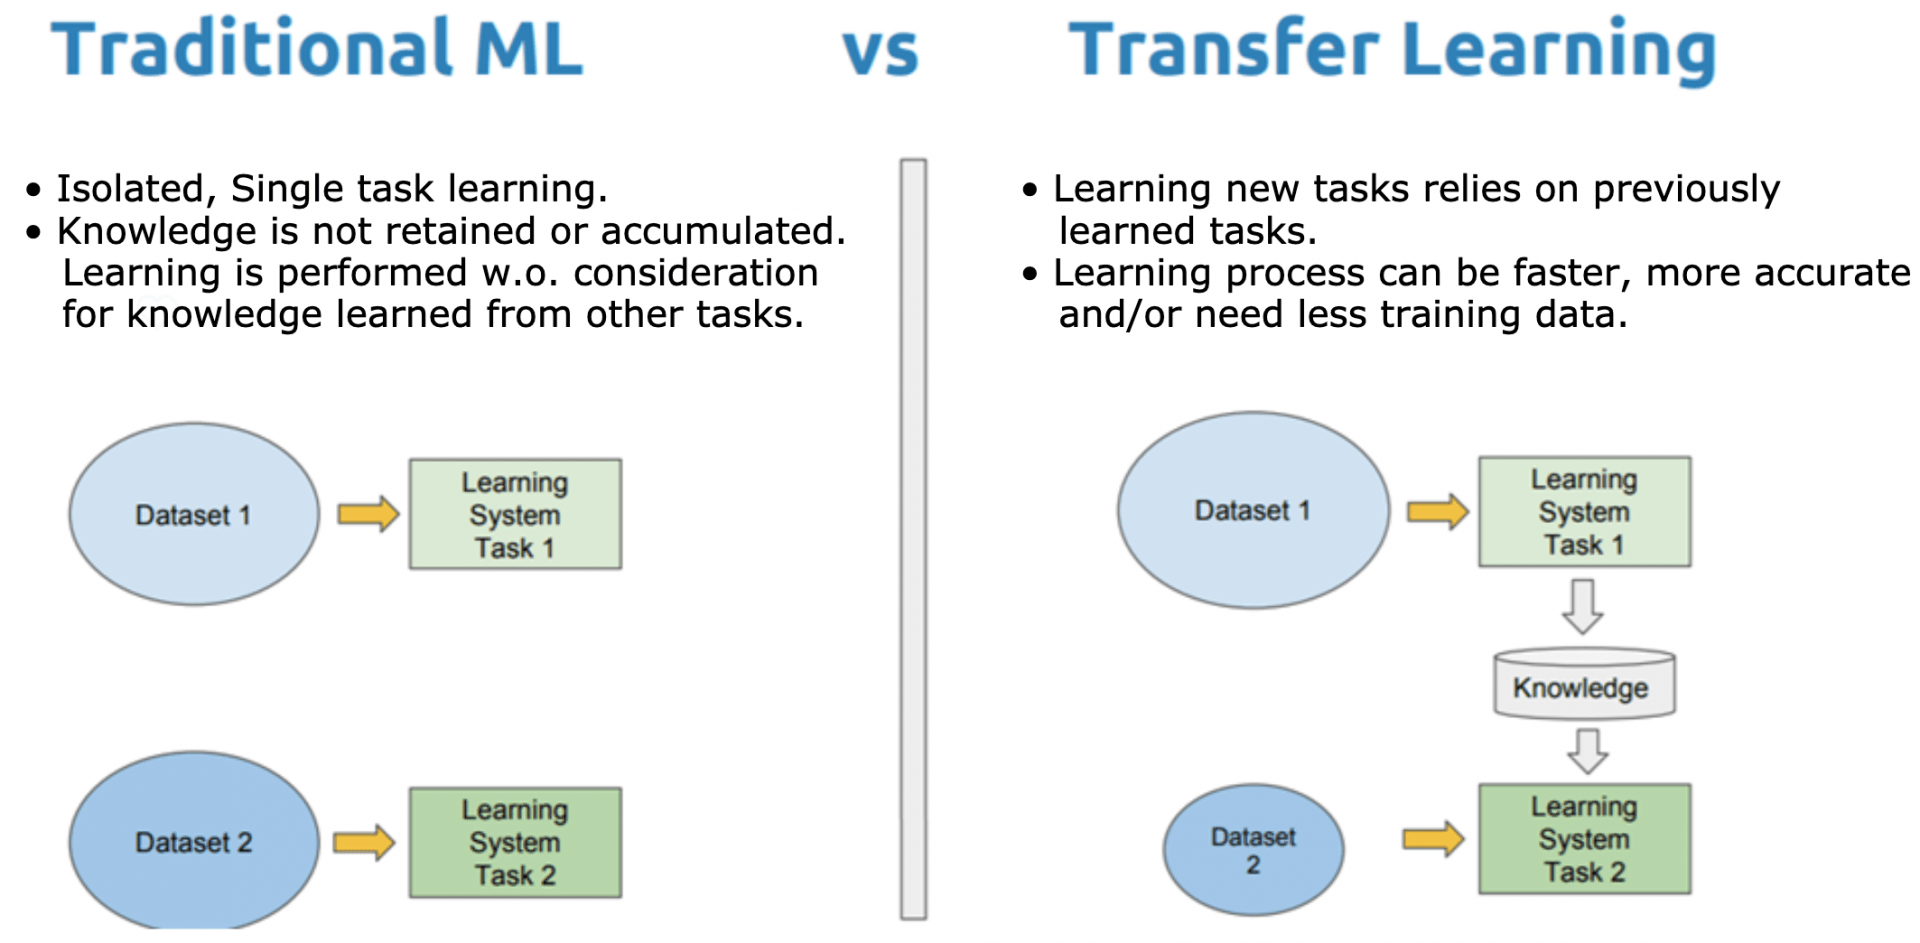

In [ ]:
# Load VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

vgg_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Binary classification output
])

vgg_model.compile(loss=BinaryCrossentropy(), optimizer=Adam(), metrics=["accuracy"])

# Define callbacks for the VGG16 model
vgg_checkpoint = ModelCheckpoint('best_model2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop_vgg = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_vgg = vgg_model.fit(
    train_data,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_data,
    validation_steps=validation_steps,
    callbacks=[vgg_checkpoint, early_stop_vgg]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9117 - loss: 0.2734
Epoch 1: val_accuracy improved from -inf to 0.91925, saving model to best_model2.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 68s 133ms/step - accuracy: 0.9118 - loss: 0.2732 - val_accuracy: 0.9192 - val_loss: 0.2060
Epoch 2/10
  1/452 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9688 - loss: 0.1423
Epoch 2: val_accuracy did not improve from 0.91925
452/452 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9688 - loss: 0.1423 - val_accuracy: 0.9173 - val_loss: 0.2128
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9693 - loss: 0.0875
Epoch 3: val_accuracy did not improve from 0.91925
452/452 ━━━━━━━━━━━━━━━━━━━━ 141s 234ms/step - accuracy: 0.9693 - loss: 0.0875 - val_accuracy: 0.9170 - val_loss: 0.2060
Epoch 4/10
  1/452 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.9688 - loss: 0.0860
Epoch 4: val_accuracy improved from 0.91925 to 0.92457, saving model to best_model2.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.9688 - loss: 0.0860 - val_accuracy: 0.9246 - val_loss: 0.1892
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9728 - loss: 0.0730
Epoch 5: val_accuracy improved from 0.92457 to 0.94227, saving model to best_model2.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 57s 127ms/step - accuracy: 0.9728 - loss: 0.0730 - val_accuracy: 0.9423 - val_loss: 0.1535
Epoch 6/10
  1/452 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 1.0000 - loss: 0.0243
Epoch 6: val_accuracy did not improve from 0.94227
452/452 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 1.0000 - loss: 0.0243 - val_accuracy: 0.9412 - val_loss: 0.1572
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9798 - loss: 0.0593
Epoch 7: val_accuracy improved from 0.94227 to 0.94587, saving model to best_model2.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 115s 129ms/step - accuracy: 0.9798 - loss: 0.0593 - val_accuracy: 0.9459 - val_loss: 0.1411
Epoch 8/10
  1/452 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 1.0000 - loss: 0.0365
Epoch 8: val_accuracy did not improve from 0.94587
452/452 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 1.0000 - loss: 0.0365 - val_accuracy: 0.9455 - val_loss: 0.1414
Epoch 9/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9805 - loss: 0.0536
Epoch 9: val_accuracy improved from 0.94587 to 0.95285, saving model to best_model2.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 58s 129ms/step - accuracy: 0.9805 - loss: 0.0536 - val_accuracy: 0.9528 - val_loss: 0.1284
Epoch 10/10
  1/452 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9688 - loss: 0.1344
Epoch 10: val_accuracy did not improve from 0.95285
452/452 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9688 - loss: 0.1344 - val_accuracy: 0.9524 - val_loss: 0.1303


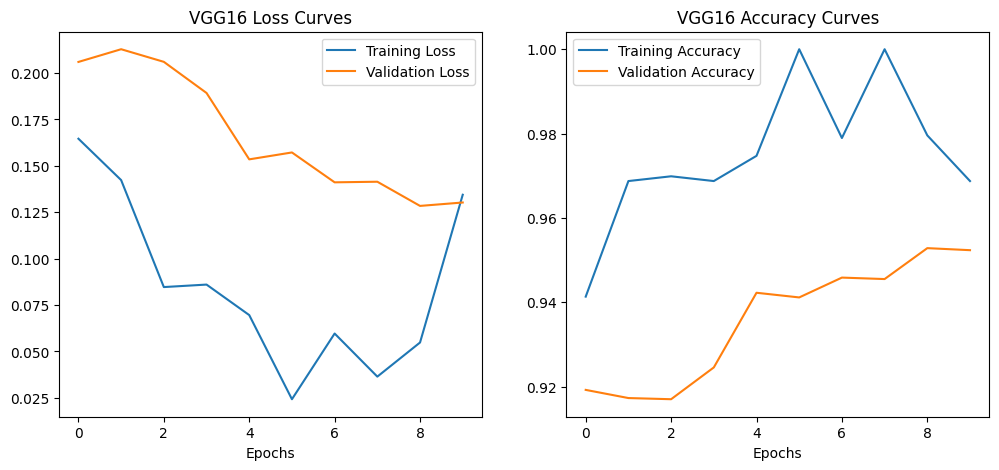

In [ ]:
# Function to plot loss and accuracy curves
plot_curves(history_vgg, title_prefix="VGG16")

In [ ]:
# Evaluate the model
result_vgg = vgg_model.evaluate(test_data, verbose=2)
print(f"VGG16 Evaluation Accuracy: {result_vgg[1]*100:.2f}%\nLoss: {result_vgg[0]:.4f}")

453/453 - 29s - 63ms/step - accuracy: 0.9528 - loss: 0.1285
VGG16 Evaluation Accuracy: 95.28%
Loss: 0.1285


# Explanation of VGG16 and Its Impact on Model Performance
## **Why We Used VGG16**: In the context of image classification tasks, such as detecting brain tumors from MRI scans, the choice of model architecture is critical for achieving high accuracy. VGG16, a convolutional neural network (CNN) architecture, is renowned for its effectiveness in visual recognition tasks. Here are some reasons why we chose VGG16 for our transfer learning approach:

**Pre-trained Weights**: VGG16 is pre-trained on the ImageNet dataset, which contains millions of labeled images across thousands of classes. This extensive training allows the model to learn rich feature representations that are transferable to other image classification tasks, like our brain tumor detection problem.

Deep Architecture: VGG16 consists of 16 layers (13 convolutional layers and 3 fully connected layers) that can learn increasingly abstract features from the input images. The deep architecture enables it to capture complex patterns in the data, which is crucial for tasks involving medical images.

Simplicity and Effectiveness: The VGG architecture is characterized by its simplicity, using small (3x3) convolutional filters and max pooling layers. This design helps to reduce the number of parameters while maintaining high performance, making it easier to train and less prone to overfitting.

# *How VGG16 Works*
VGG16 is built on a series of convolutional layers followed by max pooling layers. Here’s a high-level overview of how it operates:

**Convolutional Layers**: These layers apply filters to the input images to extract features. In VGG16, multiple convolutional layers are stacked, which allows the model to learn both low-level features (like edges and textures) and high-level features (like shapes and patterns).

**Max Pooling Layers**: After each set of convolutional layers, max pooling layers downsample the feature maps. This reduces the spatial dimensions, which helps decrease computational complexity and allows the model to become invariant to small translations in the input.

**Fully Connected Layers**: After several convolutional and pooling layers, the output feature maps are flattened and passed through fully connected layers. These layers perform high-level reasoning and classification based on the learned features. In the case of binary classification (such as detecting the presence or absence of a tumor), the final layer uses a sigmoid activation function.

**Transfer Learning**: By using the pre-trained weights of VGG16, we initialize our model with a strong set of learned features. This helps our model converge faster during training and often results in better performance compared to training a CNN from scratch, especially when the dataset is relatively small.

###***How VGG16 Helped Improve Our Accuracy***

Better Feature Extraction: The pre-trained VGG16 model provides a robust feature extractor that leverages its extensive training on diverse images. This allows it to generalize well to the specific features of MRI scans, significantly improving classification accuracy.

Reduced Training Time: By starting with a model that has already learned useful representations, we reduce the time and computational resources required to train our model on a smaller dataset, which helps prevent overfitting.

Higher Performance on Small Datasets: Transfer learning is particularly beneficial when the available dataset is limited, as is often the case in medical imaging. VGG16's ability to leverage learned features from a large dataset helps compensate for the lack of sufficient training data.

Fine-tuning Potential: After training with the frozen layers, we can further fine-tune some of the VGG16 layers by unfreezing them and training with a lower learning rate. This process helps adapt the model more specifically to our dataset, further improving accuracy.

#Conclusion
In summary, the implementation of VGG16 for transfer learning in our brain tumor detection task has provided significant advantages. Its pre-trained architecture, coupled with its ability to learn rich feature representations, has allowed us to achieve higher accuracy while training on a limited dataset. This approach not only enhances model performance but also highlights the power of transfer learning in advancing the field of medical image classification. By leveraging established models like VGG16, we can accelerate progress in developing reliable and accurate diagnostic tools in healthcare.

In [ ]:
#Load the best models
from tensorflow.keras.models import load_model

# Load the best CNN model
best_cnn_model = load_model('best_model1.h5')

# Load the best VGG16 model
best_vgg_model = load_model('best_model2.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Raw prediction value: 0.7985158


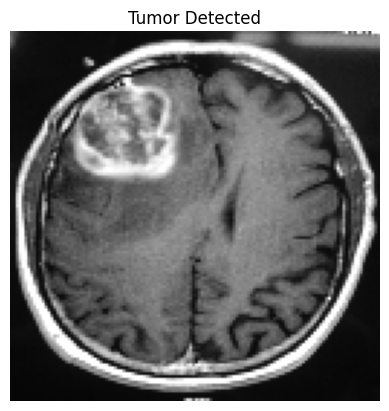

Prediction using VGG16 model: Tumor Detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Raw prediction value: 0.030117156


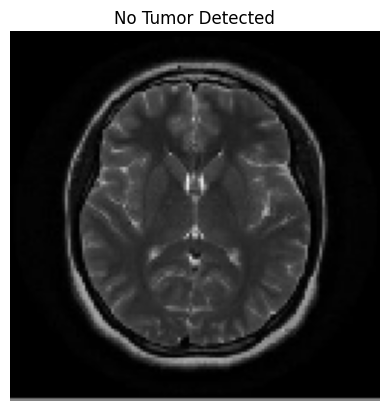

Prediction using VGG16 model: No Tumor Detected


In [ ]:
# Prediction Function
def predict_image(model, image_path):
    """
    Predicts if there is a tumor in the MRI image.

    Args:
        model: Trained model.
        image_path (str): Path to the MRI image.

    Returns:
        str: Prediction result - 'Tumor Detected' or 'No Tumor Detected'.
    """
    img = cv2.imread(image_path)
    if img is None:
        print("Error loading image.")
        return None
    # Preprocess the image
    img_resized = cv2.resize(img, IMG_SHAPE)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_normalized = img_rgb / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)

    # Make prediction
    prediction = model.predict(img_input)
    print("Raw prediction value:", prediction[0][0])
    result = "Tumor Detected" if prediction[0][0] >= 0.5 else "No Tumor Detected"

    # Display the image and result
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(result)
    plt.show()

    return result


# Example Usage of the Prediction Function

# Replace the image paths with your own test images
image_path = "/content/R.jpg"
prediction1 = predict_image(best_vgg_model, image_path)
print(f"Prediction using VGG16 model: {prediction1}")

image_path = "/content/nei.jpg"
prediction2 = predict_image(best_vgg_model, image_path)
print(f"Prediction using VGG16 model: {prediction2}")